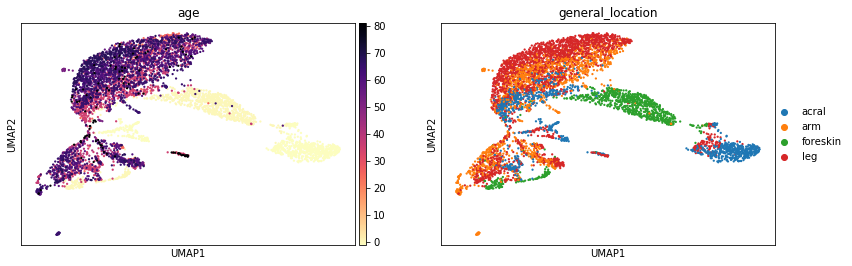

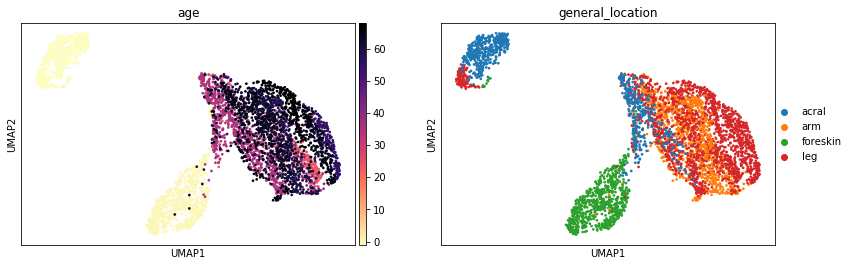

Completed


In [76]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# drop patients due to low cell count
adata_subset2_filtered = adata_subset2[[x not in ['A1015LM',
                                                'A1017LM',
                                                'A1012M'] for x in adata_subset2.obs.patient.tolist()]] 

# plot full data
sc.pl.umap(full_adata, color=['age','general_location'], cmap = 'magma_r')
sc.pl.umap(adata_subset2_filtered, color=['age','general_location'], cmap = 'magma_r')

print('Completed')


   PC        f1
0   1  0.033755
1   2  0.713318
2   3  0.008584
3   4  0.000000
4   5  0.050633
5   6  0.008475
6   7  0.000000
7   8  0.000000
8   9  0.000000
9  10  0.008621


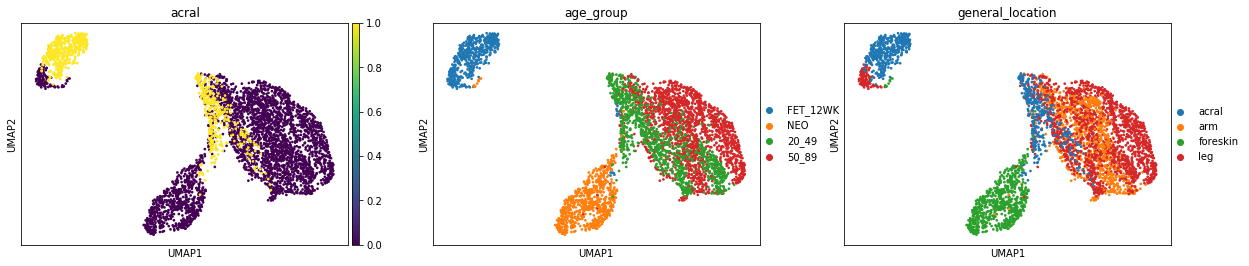

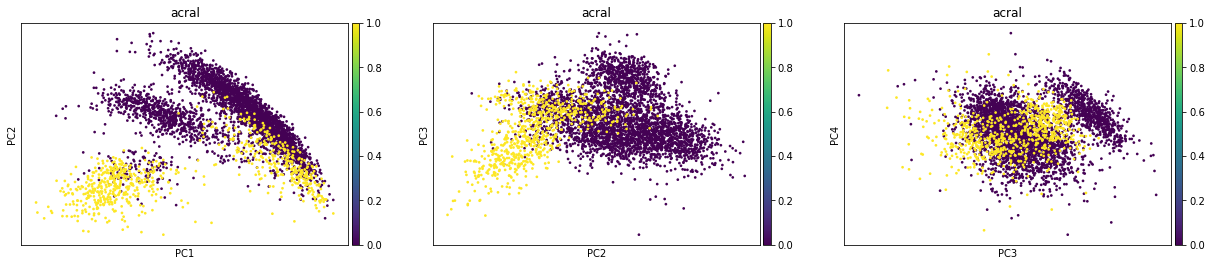

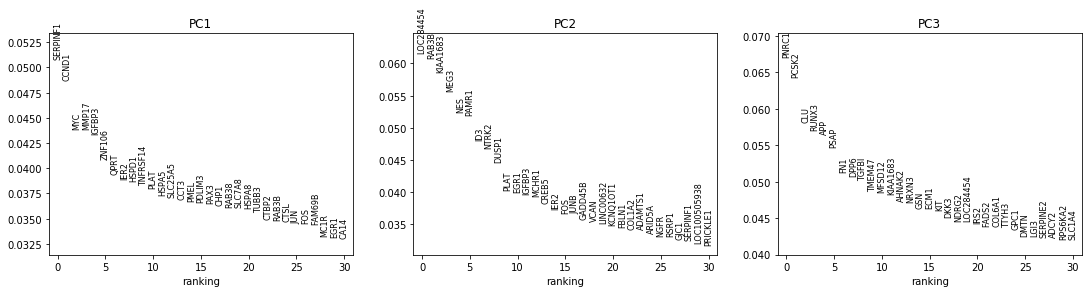

In [6]:
# determine which pc coordinate set best recalls general location label
input_adata = adata_subset2_filtered
groupby = 'acral'
input_adata.obs[groupby] = [x in [groupby] for x in input_adata.obs.general_location.values]

results_list = []
cell_list = input_adata.obs_names
loc_list = input_adata.obs[groupby].values
for PC in range(input_adata.obsm['X_pca'].shape[1]):
    PC_list = input_adata.obsm['X_pca'][:,PC]
    
    pred = PC_list # must be continuous
    res = np.array(loc_list) # must be categorical
    pred = pred.reshape(-1,1)
    res = res.reshape(-1,1)
    
    if len(np.unique(res)) == 1:
        acc = 0
    else:
        X_train, X_test, y_train, y_test = train_test_split(pred,
                                                            res,
                                                            test_size=0.33, 
                                                            random_state=42)
        # accurcy
        clf = LogisticRegression(multi_class='auto')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc  = f1_score(y_true = y_test, 
                        y_pred = y_pred, 
                        average = 'binary')
        
        results_list.append(acc)
print(pd.DataFrame({'PC':[x+1 for x in range(len(results_list))],
              'f1':results_list}).head(10))

sc.pl.umap(input_adata, color=[groupby,'age_group','general_location'])
sc.pl.pca(input_adata, components=['1,2','2,3','3,4'], color=[groupby])
sc.pl.pca_loadings(input_adata)

key = class_3, value = in, matched = 546
	Cells: 546, Genes: 23783
Process expression data...
	Initial:
	Cells: 546, Genes: 23783
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 14546
	Result:
	Cells: 546, Genes: 9237
Principle component analysis...


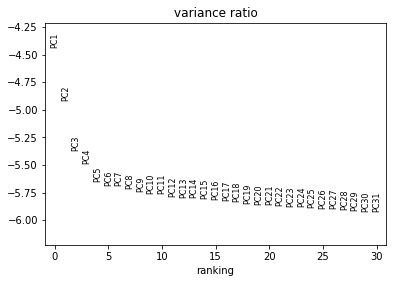

principle_components(num_pcs): 30
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


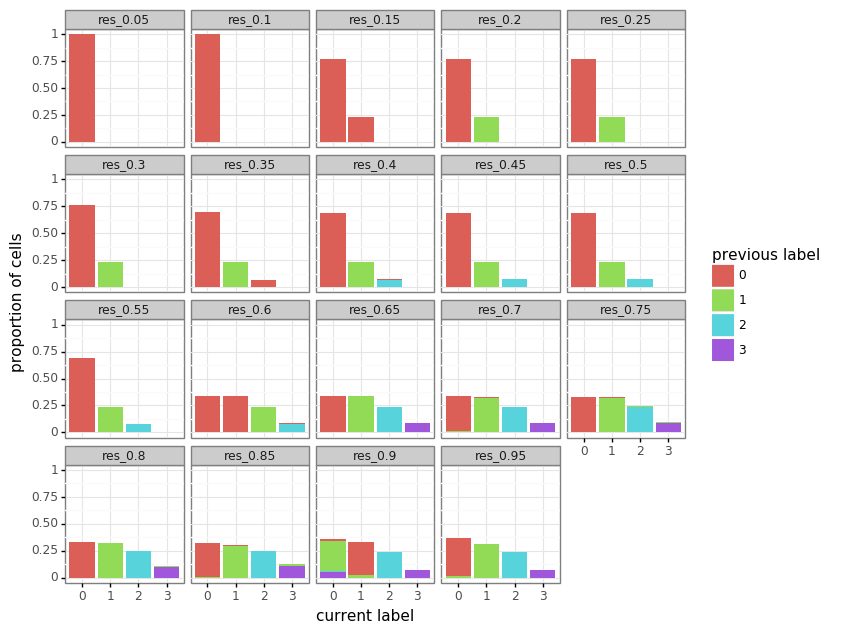

<ggplot: (-9223363270842672282)>


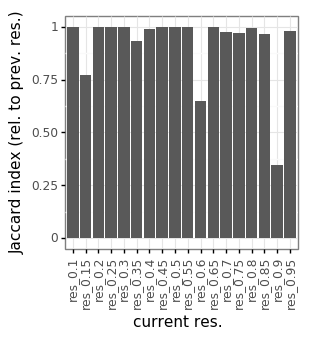

<ggplot: (-9223363270846048887)>
resolution(res): 0.2


... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_3' as categorical


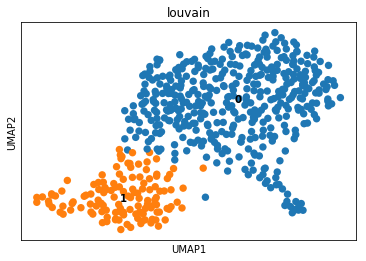

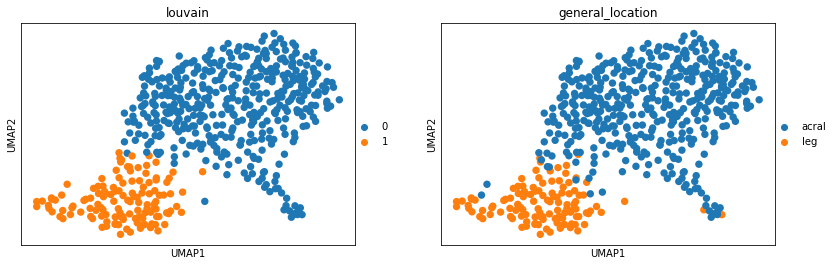

AttributeError: 'DataFrame' object has no attribute 'louvain'

In [75]:
# patients with acral + cutaneous: A1038LM, 12WKM01
patientOIs = ['12WKM01', 'A1038LM']

gene_list = []
for patientOI in patientOIs:
    input_adata = adata_subset2_filtered
    patients = list(set(input_adata.obs.patient))
    type_dict = {'in':[patientOI],
                 'out':[x for x in patients if x != patientOI]}

    classify_type(raw_adata, input_adata, 'patient', type_dict, 'class_3')

    feature_dict = {'class_3':['in']}
    adata_subset3 = subset_adata_v3(raw_adata,feature_dict)
    adata_subset3 = process_adata(adata_subset3)
    pca_adata(adata_subset3, num_pcs=30)
    umap_adata(adata_subset3, res=0.2)
    sc.pl.umap(adata_subset3, color=['louvain','general_location'])

    input_adata = adata_subset3
    ranks_df = simple_rank (input_adata, groupby='louvain', n_genes=50)
    gene_union = list(set(ranks_df.louvain))
    gene_list.append(gene_union)

In [ ]:
union_df = pd.DataFrame({'genes':[x for sublist in gene_list for x in sublist]})['genes'].value_counts()
genes = union_df[union_df > 1].index.tolist()
sc.pl.umap(adata_subset2_filtered, color=genes, ncols = 2)
sc.pl.umap(full_adata, color=genes, ncols = 2)
out = symbol2field(genes)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
search_term = ''
[print(x) for x in full_report if search_term in x]


In [ ]:
# cluster with 2 acral samples + 1 fskin